In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from time_trans_vae import Time_Trans_VAE
from tools import MinMaxScaler
from evaluation_model import disc_eva, fore_eva

## Prepare data

In [2]:
dataset = 'sine_cpx'            #use Sine_cpx as an example  
valid_perc = 0.1
train_perc = 1-valid_perc
full_train_data = np.load('../datasets/'+dataset+'.npy')
N, T, D = full_train_data.shape

In [3]:
N_train = int(N * (1 - valid_perc))
N_valid = N - N_train
np.random.shuffle(full_train_data)
train_data = full_train_data[:N_train]
valid_data = full_train_data[N_train:]
scaler = MinMaxScaler()        
x_train = scaler.fit_transform(train_data)
x_valid = scaler.transform(valid_data)

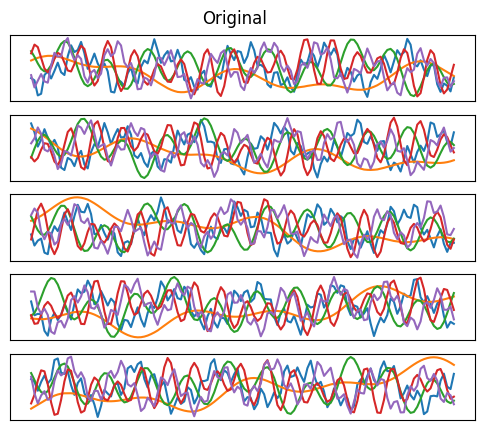

In [4]:
fig, axs = plt.subplots(5, 1, figsize=(6,5), sharex=True)
for i in range(5):
    rnd_idx = np.random.choice(len(x_train))
    s = x_train[rnd_idx]
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].plot(s)
st = plt.suptitle('Original')
st.set_y(0.93)

## Build model

In [5]:
ts_shape = x_train.shape[1:]
latent = 16

In [ ]:
latent_dim = 16
vae = Time_Trans_VAE(seq_len=T, feat_dim = D, latent_dim = latent_dim, 
                     hidden_layer_sizes=[64, 128, 256],
                     dilations = [1,2,4],
                     k_size = 4,
                     head_size = 64,
                     num_heads = 3,
                     dropout = 0.1,
                     reconstruction_wt = 3,
)

In [6]:
vae.compile(optimizer=Adam(learning_rate=0.001))
vae.summary()
early_stop_loss = 'loss'
early_stop_callback = EarlyStopping(monitor=early_stop_loss, min_delta = 1e-1, patience=7) 
reduceLR = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, min_lr=1e-06)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 5)]     0                                            
__________________________________________________________________________________________________
enc_conv_0 (Conv1D)             (None, 64, 64)       1024        encoder_input[0][0]              
__________________________________________________________________________________________________
enc_conv_1 (Conv1D)             (None, 32, 128)      24704       enc_conv_0[0][0]                 
__________________________________________________________________________________________________
enc_conv_2 (Conv1D)             (None, 16, 256)      98560       enc_conv_1[0][0]                 
____________________________________________________________________________________________

## Train model

In [ ]:
vae.fit(
    x_train, 
    batch_size = 32,
    epochs=500,
    shuffle = True,
    callbacks=[early_stop_callback, reduceLR],
    verbose = 1
)

Epoch 1/500
141/141 [==============================] - 5s 32ms/step - loss: 1073.5483 - reconstruction_loss: 216.8565 - kl_loss: 425.2252
Epoch 2/500
141/141 [==============================] - 5s 32ms/step - loss: 1075.0222 - reconstruction_loss: 216.2925 - kl_loss: 424.2658
Epoch 3/500
141/141 [==============================] - 5s 32ms/step - loss: 1076.5744 - reconstruction_loss: 217.9391 - kl_loss: 423.5245
Epoch 4/500
141/141 [==============================] - 4s 32ms/step - loss: 1070.2463 - reconstruction_loss: 216.0339 - kl_loss: 420.5000
Epoch 5/500
141/141 [==============================] - 5s 34ms/step - loss: 1071.2789 - reconstruction_loss: 216.4076 - kl_loss: 424.7365
Epoch 6/500
141/141 [==============================] - 4s 32ms/step - loss: 1065.8306 - reconstruction_loss: 216.5608 - kl_loss: 423.2193
Epoch 7/500
141/141 [==============================] - 4s 31ms/step - loss: 1073.1181 - reconstruction_loss: 216.5909 - kl_loss: 424.1741
Epoch 8/500
141/141 [=============

In [ ]:
num_samples = N_train
sample = vae.get_prior_samples(num_samples=num_samples)

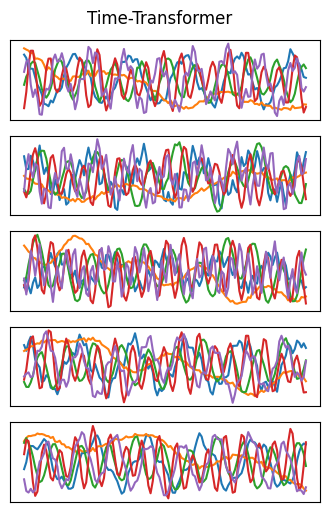

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(4,6), sharex=True)
for i in range(5):
    rnd_idx = np.random.choice(len(sample))
    s = sample[rnd_idx]
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].plot(s)
st = plt.suptitle('Time-Transformer')
st.set_y(0.93)

## Visualization

In [21]:
train_ori = np.mean(x_train, axis=-1)
train_gen = np.mean(sample, axis=-1)

In [22]:
select = x_train.shape[0]
idx = np.random.permutation(select)
ori = train_ori[idx]
gen = train_gen[idx]
prep_data_final = np.concatenate((ori, gen), axis = 0)

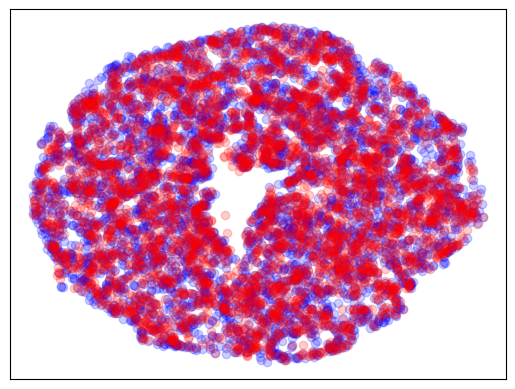

In [23]:
emb = TSNE(n_components=2, learning_rate=10, init = 'random', perplexity=50, n_iter=400).fit_transform(prep_data_final)
plt.yticks([])
plt.xticks([])
plt.scatter(emb[:select, 0], emb[:select, 1], alpha=0.2, color='b')
plt.scatter(emb[select:, 0], emb[select:, 1], alpha=0.2, color='r')

## Save generated data

In [23]:
np.save('save_model/gen_'+dataset+'.npy', sample)